# Preprocessing

In [35]:
# import packages
import os
from sklearn.linear_model import LogisticRegression
import numpy as np
from nilearn import image
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from scipy import stats

In [36]:
## get list of subject directories
proj_dir = '/home/jefan/sketchloop02/'
contents_dir = os.listdir(proj_dir)

sub_dirs = []
for i in contents_dir:
    try:
        if i.split('_')[1]=='neurosketch':
            sub_dirs.append(i)
    except:
        pass

sub_dirs = sorted(sub_dirs)

# issue with 1207161
sub_dirs = [s for s in sub_dirs if s != '1207161_neurosketch']

# issue with 1201161
sub_dirs = [s for s in sub_dirs if s != '1201161_neurosketch']

print(sub_dirs)
print(str(len(sub_dirs)) + ' subjects')

['0110171_neurosketch', '0110172_neurosketch', '0111171_neurosketch', '0112171_neurosketch', '0112172_neurosketch', '0112173_neurosketch', '0113171_neurosketch', '0115172_neurosketch', '0115174_neurosketch', '0117171_neurosketch', '0118171_neurosketch', '0118172_neurosketch', '0119171_neurosketch', '0119172_neurosketch', '0119173_neurosketch', '0119174_neurosketch', '0120171_neurosketch', '0120172_neurosketch', '0120173_neurosketch', '0123171_neurosketch', '0123173_neurosketch', '0124171_neurosketch', '0125171_neurosketch', '0125172_neurosketch', '1121161_neurosketch', '1130161_neurosketch', '1202161_neurosketch', '1203161_neurosketch', '1206161_neurosketch', '1206162_neurosketch', '1206163_neurosketch', '1207162_neurosketch']
32 subjects


In [37]:
# analysis helper functions
def get_mask_array(mask_path):
    # loads mask applied to nifty (.nii.gz) file
    # mask selects voxels to be included/discarded
    mask_img = image.load_img(mask_path)
    mask_data = mask_img.get_data()
    num_brain_voxels = sum(sum(sum(mask_data==1)))
    return mask_data, num_brain_voxels

def load_roi_mask_combined(subj,run_num,roi):
    if run_num in [1,2]:
        phase_num = '12' 
    elif run_num in [3,4]:
        phase_num = '34'
    elif run_num in [5,6]:
        phase_num = '56'
    mask_path = proj_dir + '/' + subj +'/analysis/firstlevel/rois/' + roi + '_func_combined_' + phase_num + '_binarized.nii.gz'        
    mask_data, nv = get_mask_array(mask_path)
    return mask_data

# Vanilla Performance Between Runs

In [13]:
# train on run 1, test on run 2 using SVM or 4-way softmax (logistic regression classifier)
# how to define training set?
# get the 80 cope maps for run 1 per subject
# i'll do it for the whole brain and then with ROI masks applied, compare results

# this time, we only pick one instead of (presumably at +3, maybe +2) 
ROIs = ['V1','fusiform','IT','LOC', 'occitemp']
roiscores = []

for roi in ROIs:
    print(roi)
    actual = []
    predicted = []
    for subject in sub_dirs:
        print(subject)
        trainingX = []
        trainingY = []
        testX = []
        testY = []
        roi_mask = load_roi_mask_combined(subject, 1, roi)
        for run in [1, 2]:

            # load subject's time series for this run
            timeseries = image.load_img(proj_dir + subject + '/analysis/firstlevel/preproc_recognition_run_' +
                                                 str(run) + '.feat/filtered_func_data.nii.gz')
            timeseries = timeseries.get_data().transpose((3, 0, 1, 2))
            #timeseries = stats.zscore(timeseries, axis=0)
            #timeseries[np.isnan(timeseries)] = 0
            
            # use information in regressor/run_x folder to make hasImage vector
            hasImage = [0]*240
            for cope in ['bed', 'bench', 'chair', 'table']:
                with open('/home/jgunn/neurosketch/timepoints/' + subject[:7] + '_' + str(run) + '_' + cope + '.txt') as f:
                    times = [line.split(' ')[0] for line in f.read().split('\n')[:-1]]
                    for t in times:
                        tr = float(t)/1.5
                        if cope == 'bed':
                            hasImage[int(tr)] = 1
                        elif cope == 'bench':
                            hasImage[int(tr)] = 2
                        elif cope == 'chair':
                            hasImage[int(tr)] = 3
                        elif cope == 'table':
                            hasImage[int(tr)] = 4

            # wherever hasImage, get associated volume and flatten it for training
            for i, has in enumerate(hasImage): # 80 times
                if has > 0:
                    if run == 1:
                        trainingX.append(timeseries[i+3][roi_mask==1])
                        trainingY.append(has-1)
                    else:
                        testX.append(timeseries[i+3][roi_mask==1])
                        testY.append(has-1)

        lin_clf = LogisticRegression()
        lin_clf.fit(trainingX, trainingY)
        predicted = predicted + lin_clf.predict(testX).tolist()
        actual = actual + testY
        #scores = scores + [np.mean(cross_val_score(lin_clf, trainingX, trainingY).tolist())]
    roiscores.append(np.mean(np.equal(actual, predicted)))
    
roiscores

V1
0110171_neurosketch
0110172_neurosketch
0111171_neurosketch
0112171_neurosketch
0112172_neurosketch
0112173_neurosketch
0113171_neurosketch
0115172_neurosketch
0115174_neurosketch
0117171_neurosketch
0118171_neurosketch
0118172_neurosketch
0119171_neurosketch
0119172_neurosketch
0119173_neurosketch
0119174_neurosketch
0120171_neurosketch
0120172_neurosketch
0120173_neurosketch
0123171_neurosketch
0123173_neurosketch
0124171_neurosketch
0125171_neurosketch
0125172_neurosketch
1121161_neurosketch
1130161_neurosketch
1202161_neurosketch
1203161_neurosketch
1206161_neurosketch
1206162_neurosketch
1206163_neurosketch
1207162_neurosketch
fusiform
0110171_neurosketch
0110172_neurosketch
0111171_neurosketch
0112171_neurosketch
0112172_neurosketch
0112173_neurosketch
0113171_neurosketch
0115172_neurosketch
0115174_neurosketch
0117171_neurosketch
0118171_neurosketch
0118172_neurosketch
0119171_neurosketch
0119172_neurosketch
0119173_neurosketch
0119174_neurosketch
0120171_neurosketch
0120172_

[0.25624999999999998,
 0.25429687499999998,
 0.25117187499999999,
 0.27109375000000002,
 0.26171875]

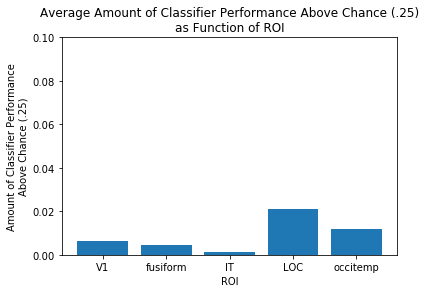

array([ 0.25625   ,  0.25429687,  0.25117187,  0.27109375,  0.26171875])

In [19]:
plt.bar(np.arange(5), np.array(roiscores) - .25)
plt.xticks(np.arange(5), ROIs)
plt.ylabel('Amount of Classifier Performance\nAbove Chance (.25)')
plt.xlabel('ROI')
plt.ylim(ymax=.1)
plt.title('Average Amount of Classifier Performance Above Chance (.25)\nas Function of ROI')
plt.show()
np.array(roiscores)

# Main Analysis

In [38]:
import warnings
warnings.filterwarnings('ignore')

import nibabel as nib
import numpy as np
import brainiak
import os
import json
import seaborn as sns
import _pickle as cPickle
import matplotlib.pyplot as plt
import analysis_helpers as helpers
from nilearn import image
from numpy import shape
from brainiak.searchlight.searchlight import Searchlight
from brainiak.searchlight.searchlight import Diamond
from sklearn.metrics.pairwise import pairwise_distances as pd
from timeit import default_timer as timer

In [39]:
# load in experimental design pickle file
with open('morph_drawing_training_design.pkl', 'rb') as f:
    mdtd = cPickle.load(f, encoding='latin1') 

In [40]:
## cope numbering legend
## cope1 = 'bed'
## cope2 = 'bench'
## cope3 = 'chair'
## cope4 = 'table'

cope2obj = {'cope1':'bed','cope2':'bench', 'cope3':'chair','cope4':'table'}
obj2cope = {'bed':1,'bench':2, 'chair':3,'table':4}

In [41]:
# behavioral data from database
with open('versionNums.json') as json_data:
    coll = json.load(json_data)

In [42]:
## get list of subject directories
proj_dir = '/home/jefan/sketchloop02/'
contents_dir = os.listdir(proj_dir)

sub_dirs = []
for i in contents_dir:
    try:
        if i.split('_')[1]=='neurosketch':
            sub_dirs.append(i)
    except:
        pass

sub_dirs = sorted(sub_dirs)

# issue with 1207161
sub_dirs = [s for s in sub_dirs if s != '1207161_neurosketch']

# issue with 1201161
sub_dirs = [s for s in sub_dirs if s != '1201161_neurosketch']

print(sub_dirs)
def print(str(len(sub_dirs)) + ' subjects')

['0110171_neurosketch', '0110172_neurosketch', '0111171_neurosketch', '0112171_neurosketch', '0112172_neurosketch', '0112173_neurosketch', '0113171_neurosketch', '0115172_neurosketch', '0115174_neurosketch', '0117171_neurosketch', '0118171_neurosketch', '0118172_neurosketch', '0119171_neurosketch', '0119172_neurosketch', '0119173_neurosketch', '0119174_neurosketch', '0120171_neurosketch', '0120172_neurosketch', '0120173_neurosketch', '0123171_neurosketch', '0123173_neurosketch', '0124171_neurosketch', '0125171_neurosketch', '0125172_neurosketch', '1121161_neurosketch', '1130161_neurosketch', '1202161_neurosketch', '1203161_neurosketch', '1206161_neurosketch', '1206162_neurosketch', '1206163_neurosketch', '1207162_neurosketch']
32 subjects


In [31]:
mask={}
roi = 'IT'
for subject in sub_dirs:
    print(subject)
    trainingX = []
    trainingY = []
    testX = []
    testY = []
    
    roi_mask = load_roi_mask_combined(subject, 1, roi)
    print(np.sum(roi_mask))
    for run in [1, 2]:

        # load subject's time series for this run
        timeseries = image.load_img(proj_dir + subject + '/analysis/firstlevel/preproc_recognition_run_' +
                                             str(run) + '.feat/filtered_func_data.nii.gz')
        timeseries = timeseries.get_data().transpose((3, 0, 1, 2))
        
        # use information in regressor/run_x folder to make hasImage vector
        hasImage = [0]*240
        for cope in ['bed', 'bench', 'chair', 'table']:
            with open('/home/jgunn/neurosketch/timepoints/' + subject[:7] + '_' + str(run) + '_' + cope + '.txt') as f:
                times = [line.split(' ')[0] for line in f.read().split('\n')[:-1]]
                for t in times:
                    tr = float(t)/1.5
                    if cope == 'bed':
                        hasImage[int(tr)] = 1
                    elif cope == 'bench':
                        hasImage[int(tr)] = 2
                    elif cope == 'chair':
                        hasImage[int(tr)] = 3
                    elif cope == 'table':
                        hasImage[int(tr)] = 4
        
        # wherever hasImage, get associated volume and flatten it for training
        for i, has in enumerate(hasImage): # 80 times
            if has > 0:
                if run == 1:
                    trainingX.append(timeseries[i+3][roi_mask==1])
                    trainingY.append(has-1)
                else:
                    testX.append(timeseries[i+3][roi_mask==1])
                    testY.append(has-1)
                    
    lin_clf = LogisticRegression()
    rfecv = RFECV(estimator=lin_clf, step=.02, scoring='accuracy')
    rfecv.fit(trainingX, trainingY)
    mask[subject] = rfecv.support_

0110171_neurosketch
2015.0


KeyboardInterrupt: 

In [ ]:
## Analysis helper functions (see and update: analysis_helpers.py)
def rfecv_masked(vol, subject, roi_mask):
    print(np.sum(roi_mask))
    return vol[roi_mask==1][mask[subject]]

def getEndpoints(morphline):
    # return two components 
    if morphline=='sedanMinivan':
        return ['sedan','minivan']
    elif morphline=='minivanSportscar':
        return ['minivan','sportscar']
    elif morphline=='sportscarSUV':
        return ['sportscar','SUV']
    elif morphline=='SUVMinivan':
        return ['SUV','minivan']
    elif morphline=='sportscarSedan':
        return ['sportscar','sedan']
    elif morphline=='sedanSUV':
        return ['sedan','SUV']
    elif morphline=='bedChair':
        return ['bed','chair']
    elif morphline=='bedTable':
        return ['bed','table']
    elif morphline=='benchBed':
        return ['bench','bed']
    elif morphline=='chairBench':
        return ['chair','bench']
    elif morphline=='chairTable':
        return ['chair','table']
    elif morphline=='tableBench':
        return ['table','bench']
    elif morphline=='limoToSUV':
        return ['limo','SUV']    
    elif morphline=='limoToSedan':
        return ['sedan','limo']  
    elif morphline=='limoToSmart':
        return ['limo','smartcar']  
    elif morphline=='smartToSedan':
        return ['smartcar','sedan']    
    elif morphline=='suvToSedan':
        return ['SUV','sedan']  
    elif morphline=='suvToSmart':
        return ['SUV','smartcar']  
    else:
        return ['A','B']

def get_mask_array(mask_path):
    # loads mask applied to nifty (.nii.gz) file
    # mask selects voxels to be included/discarded
    mask_img = image.load_img(mask_path)
    mask_data = mask_img.get_data()
    num_brain_voxels = sum(sum(sum(mask_data==1)))
    return mask_data, num_brain_voxels

def load_roi_mask_combined(subj,run_num,roi):
    if run_num in [1,2]:
        phase_num = '12' 
    elif run_num in [3,4]:
        phase_num = '34'
    elif run_num in [5,6]:
        phase_num = '56'
    mask_path = proj_dir + '/' + subj +'/analysis/firstlevel/rois/' + roi + '_func_combined_' + phase_num + '_binarized.nii.gz'        
    mask_data, nv = get_mask_array(mask_path)
    return mask_data

def load_single_run_weights(subj,run_num,cope_num):
    nifti_path = proj_dir + '/' + subj + '/analysis/firstlevel/glm4_recognition_run_' + str(run_num) + \
                '.feat/stats/' + 'cope' + str(cope_num) + '.nii.gz'
    fmri_img = image.load_img(nifti_path)
    fmri_data = fmri_img.get_data()
    return fmri_data, fmri_img.affine

def get_condorder(this_sub):
    versionNum = coll[this_sub]

    design = [i for i in mdtd if i['version'] == int(versionNum)] # find which axes belong to which condition
    trained = design[0]['trained']
    near = design[0]['near']

    Tep = getEndpoints(trained)
    Nep = getEndpoints(near)
    condorder = Tep + Nep

    return (obj2cope[condorder[0]],
            obj2cope[condorder[1]],
            obj2cope[condorder[2]],
            obj2cope[condorder[3]])

def apply_mask(data,mask):
    return data[mask==1]

def load_data_and_apply_mask(subj,run_num,roi,cope_num,k):
    vol = load_single_run_weights(subj,run_num,cope_num)[0]
    mask = load_roi_mask_combined(subj,run_num,roi)
    vec = rfecv_masked(vol,subj,mask)
    return vec

def extract_condition_by_voxel_run_mat(this_sub,run_num, roi,k):
    versionNum = coll[this_sub]

    design = [i for i in mdtd if i['version'] == int(versionNum)] # find which axes belong to which condition
    trained = design[0]['trained']
    near = design[0]['near']
    far1 = design[0]['far1']
    far2 = design[0]['far2']

    Tep = getEndpoints(trained)
    Nep = getEndpoints(near)
    condorder = Tep + Nep

    slot1 = load_data_and_apply_mask(
        this_sub,run_num,roi,obj2cope[condorder[0]],k)
    slot2 = load_data_and_apply_mask(
        this_sub,run_num,roi,obj2cope[condorder[1]],k)
    slot3 = load_data_and_apply_mask(
        this_sub,run_num,roi,obj2cope[condorder[2]],k)
    slot4 = load_data_and_apply_mask(
        this_sub,run_num,roi,obj2cope[condorder[3]],k)
    return np.vstack((slot1,slot2,slot3,slot4))

def compare_btw_wit_cond_similarity_across_runs(this_sub,phase,roi,k):
    
    if phase=='pre':
        mat1 = extract_condition_by_voxel_run_mat(this_sub,3,roi,k)
        mat2 = extract_condition_by_voxel_run_mat(this_sub,4,roi,k)
    elif phase=='post':
        mat1 = extract_condition_by_voxel_run_mat(this_sub,5,roi,k)
        mat2 = extract_condition_by_voxel_run_mat(this_sub,6,roi,k)

    fAB = np.vstack((mat1,mat2)) # stack feature matrices
    # square matrix, where off-diagblock is distances *between* 
    # fA and fB vectors
    DAB = pd(fAB, metric='correlation')
    offblock = DAB[:len(mat1),range(len(mat1),shape(DAB)[1])]

    trained_witobj = offblock.diagonal()[:2]
    control_witobj = offblock.diagonal()[2:]
    trained_btwobj = np.array([offblock[:2,:2][0,1], offblock[:2,:2][1,0]])
    control_btwobj = np.array([offblock[2:,2:][0,1],offblock[2:,2:][1,0]])

    trawit_mean = trained_witobj.mean()
    conwit_mean = control_witobj.mean()
    trabtw_mean = trained_btwobj.mean()
    conbtw_mean = control_btwobj.mean()
    return trawit_mean,conwit_mean,trabtw_mean, conbtw_mean 

In [78]:
### Now compute for all subjects (N=32), and for every ROIs

k = 0
Tradiffpre = []
Condiffpre = []
Tradiffpost = []
Condiffpost = []

ROIs = [roi]

for roi in ROIs:
    print(roi)    
    _Tradiffpre = []
    _Condiffpre = []
    _Tradiffpost = []
    _Condiffpost = []
        
    for s in sub_dirs:
        print(s)
        trawit_mean_pre,conwit_mean_pre, trabtw_mean_pre,conbtw_mean_pre = \
        compare_btw_wit_cond_similarity_across_runs(s,'pre',roi,k)
        trawit_mean_post,conwit_mean_post, trabtw_mean_post,conbtw_mean_post = \
        compare_btw_wit_cond_similarity_across_runs(s,'post',roi,k)
        
        _Tradiffpre.append(trabtw_mean_pre - trawit_mean_pre)
        _Condiffpre.append(conbtw_mean_pre - conwit_mean_pre)

        _Tradiffpost.append(trabtw_mean_post - trawit_mean_post)
        _Condiffpost.append(conbtw_mean_post - conwit_mean_post)
        
    _Tradiffpre,_Condiffpre,_Tradiffpost,_Condiffpost = map(np.array, \
                                                               [_Tradiffpre,_Condiffpre,_Tradiffpost,_Condiffpost])
        
    if len(Tradiffpre)==0:
        Tradiffpre = _Tradiffpre
        Condiffpre = _Condiffpre
        Tradiffpost = _Tradiffpost
        Condiffpost = _Condiffpost
    else:
        Tradiffpre = np.vstack((Tradiffpre,_Tradiffpre))
        Condiffpre = np.vstack((Condiffpre,_Condiffpre))
        Tradiffpost = np.vstack((Tradiffpost,_Tradiffpost))
        Condiffpost = np.vstack((Condiffpost,_Condiffpost))

IT
0110171_neurosketch
1901.0


IndexError: boolean index did not match indexed array along dimension 0; dimension is 1901 but corresponding boolean dimension is 2015

In [ ]:
## save out so you can import later and share
if shape(Tradiffpre)==(len(ROIs),len(sub_dirs)): ## ONLY save out if you've actually finished the analysis above
    with open("prepost_differentiation_by_condition.pkl", 'wb')  as _f:
        cPickle.dump([Tradiffpost,Tradiffpre,Condiffpost,Condiffpre], _f)

In [ ]:
## load in saved pkl
with open('prepost_differentiation_by_condition.pkl', 'rb') as f:
    prepost_diff = cPickle.load(f, encoding='latin1')

In [ ]:
tmp = np.dstack((Tradiffpre,Condiffpre))
Diffpre = tmp.mean(2)

tmp = np.dstack((Tradiffpost,Condiffpost))
Diffpost = tmp.mean(2)

In [ ]:
sns.set_style('white')
sns.set_context('poster')

means_pre = Diffpre.mean(1)
std_pre = Diffpre.std(1)/np.sqrt(shape(Diffpre)[1])

means_post = Diffpost.mean(1)
std_post = Diffpost.std(1)/np.sqrt(shape(Diffpost)[1])

fig, ax = plt.subplots(figsize=(10,6))

n_groups = 6 # num ROIs
index = np.arange(n_groups)
bar_width = 0.35

opacity = 0.8
error_config = {'ecolor': '0.3'}

## plot means as bars
tcolor = (0.4,0.4,0.4)
rects1 = plt.bar(index, means_pre, bar_width,
                 alpha=opacity,
                 color=(0.4,0.4,0.4),
                 yerr=std_pre,
                 error_kw=error_config,
                 label='Pre')

ccolor = (0.7,0.7,0.7)
rects2 = plt.bar(index + bar_width, means_post, bar_width,
                 alpha=opacity,
                 color=(0.7,0.7,0.7),
                 yerr=std_post,
                 error_kw=error_config,
                 label='Post')


plt.xlabel('ROIs')
plt.ylabel('Btw vs. W/in-Obj Distance')
plt.title('Sensitivity to differences between object representations')
plt.xticks(index + bar_width / 2, ('V1','fusiform','IT','LOC','occitemp', 'searchlight'))
plt.legend()
plt.tight_layout()
plt.show()

save_out = 1
if save_out:
    helpers.save('plots/object_discriminability_by_roi_group_mean', ext='pdf', close=False, verbose=True)

In [ ]:
Tradifflearn = Tradiffpost-Tradiffpre
Condifflearn = Condiffpost-Condiffpre

In [ ]:
ROIs = ['V1','fusiform','IT','LOC','occitemp', 'searchlight']
print(Tradifflearn.std(1)/np.sqrt(shape(Tradifflearn)[1]))
print(Condifflearn.mean(1))

In [ ]:
## Generate summary plot (main analysis)

plot_indiv_subs = 1

sns.set_style('white')
sns.set_context('poster')
means_trained = Tradifflearn.mean(1)
std_trained = Tradifflearn.std(1)/np.sqrt(shape(Tradifflearn)[1])

means_control = Condifflearn.mean(1)
std_control = Condifflearn.std(1)/np.sqrt(shape(Condifflearn)[1])


fig, ax = plt.subplots(figsize=(10,6))

n_groups = 6 # num ROIs
index = np.arange(n_groups)
bar_width = 0.35

opacity = 0.8
error_config = {'ecolor': '0.3'}

## plot means as bars
tcolor = (0.8,0.4,0.4)
rects1 = plt.bar(index, means_trained, bar_width,
                 alpha=opacity,
                 color=(0.8,0.4,0.4),
                 yerr=std_trained,
                 error_kw=error_config,
                 label='Trained')

ccolor = (0.4,0.4,0.4)
rects2 = plt.bar(index + bar_width, means_control, bar_width,
                 alpha=opacity,
                 color=(0.4,0.4,0.4),
                 yerr=std_control,
                 error_kw=error_config,
                 label='Control')

if plot_indiv_subs:
    ## now plot individual subjects as dots
    def generate_concat_tiled(array,reps):        
        inds = []
        for i in index:
            inds.append(np.tile(i,reps))
        return np.reshape(np.array(inds),(1,reps*len(array)))

    tindex = generate_concat_tiled(index,len(Tradifflearn[0]))
    tsubdists = np.reshape(Tradifflearn,(1,shape(Tradifflearn)[0]*shape(Tradifflearn)[1]))
    plt.scatter(tindex,tsubdists,s=25,alpha=0.2,color=tcolor)

    cindex = generate_concat_tiled(index,len(Condifflearn[0]))+bar_width
    csubdists = np.reshape(Condifflearn,(1,shape(Condifflearn)[0]*shape(Condifflearn)[1]))
    plt.scatter(cindex,csubdists,s=25,alpha=0.2,color=ccolor)

plt.xlabel('ROIs')
plt.ylabel('Change in Representational DISTANCE')
plt.title('Effect of Training on Representational DISTANCE')
plt.xticks(index + bar_width / 2, ('V1','fusiform','IT','LOC','occitemp', 'searchlight'))
plt.legend()
plt.tight_layout()
plt.show()

save_out = 1
if save_out:
    if plot_indiv_subs:
        helpers.save('plots/differentiation_by_roi_indiv_sub', ext='pdf', close=False, verbose=True)
    else:
        helpers.save('plots/differentiation_by_roi_group_mean', ext='pdf', close=False, verbose=True)